# Import Libraries

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

# Exploratory Data Analysis

In [2]:
stock_names = ['Apple','Netflix','Google']
# Upload the stock prices into pandas dataframe
df_apple = pd.read_csv('Apple.csv',parse_dates= [0], index_col = 'date',skiprows = [1])
df_netflix = pd.read_csv('Netflix.csv',parse_dates= [0],index_col = 'date',skiprows = [1])
df_google = pd.read_csv('Google.csv',parse_dates= [0],index_col = 'date',skiprows = [1])
# Combine Closing Prices into separate dataframe
df_close= pd.concat([df_apple.close,df_netflix.close,df_google.close], axis = 1, keys = stock_names)
# Display first 5 rows
print(df_close.head())

             Apple  Netflix   Google
date                                
2019-02-22  172.97   363.02  1116.56
2019-02-21  171.06   356.97  1104.21
2019-02-20  172.03   359.91  1120.59
2019-02-19  170.93   361.92  1126.51
2019-02-15  170.42   356.87  1119.63


In [3]:
# Sort the column indexes in chronological order
df_close = df_close.sort_index()
print(df_close.head())
# Forward fill the missing holiday and weekend stock closing prices
df_close = df_close.resample('D').ffill()

              Apple  Netflix    Google
date                                  
2009-02-23  12.4214   5.0829  166.7281
2009-02-24  12.8929   5.1514  174.5023
2009-02-25  13.0229   5.1129  172.5777
2009-02-26  12.7414   5.1114  170.3248
2009-02-27  12.7586   5.1771  170.7339


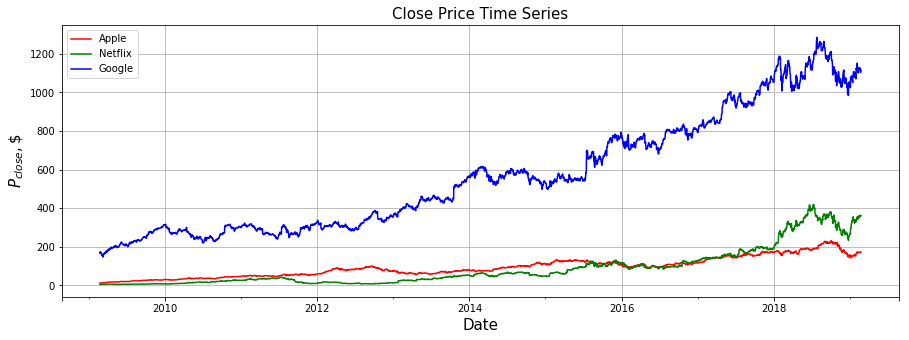

In [4]:
# Plots the original closing price time series
fig, axs = plt.subplots(1,1, figsize=(15, 5))
df_close.plot(ax= axs, color = 'rgb')
axs.set_ylabel(r'$P_{close} ,\$ $', size = '15')
axs.set_xlabel('Date', size = '15')
axs.set_title('Close Price Time Series',size = '15')
axs.grid()

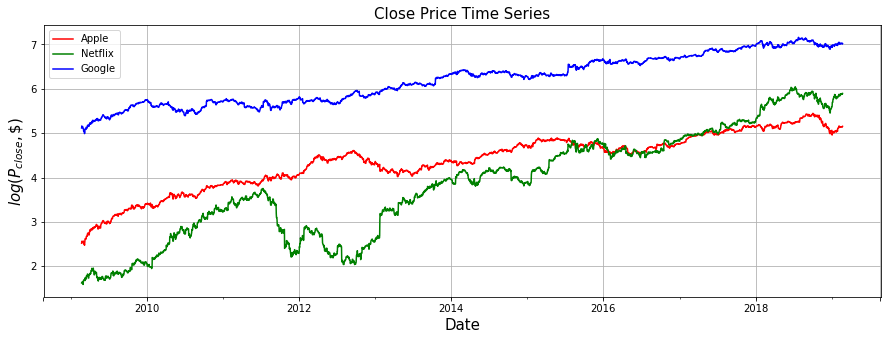

In [5]:
# Plots the log-transformed closing price time series
df_logc = np.log(df_close)
fig, axs = plt.subplots(1,1, figsize=(15, 5))
df_logc.plot(ax= axs, color = 'rgb')
axs.set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
axs.set_xlabel('Date', size = '15')
axs.set_title('Close Price Time Series',size = '15')
axs.grid()

# Candlestick Plots

Text(0.5,0,'Date')

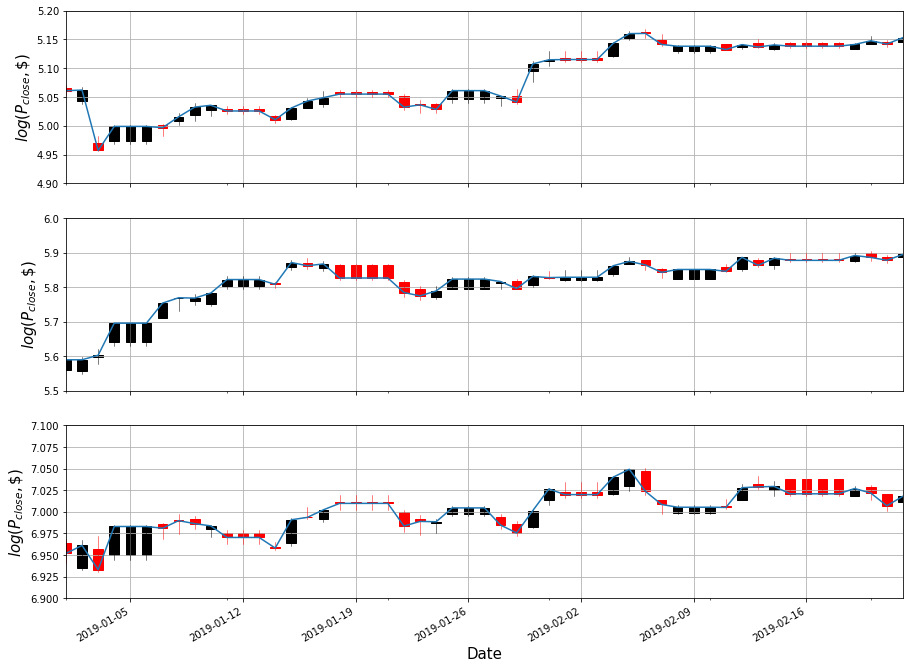

In [6]:
start_date = '2018-06-01'
fig, axs = plt.subplots(3,1, figsize=(15, 12),sharex = True)
for i in range(3):
    # Candlestick Plot
    stock = pd.read_csv(stock_names[i]+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1],infer_datetime_format=True)
    stock= stock.resample('D').ffill()
    stock = np.log(stock)
    candlestick_ohlc(axs[i], zip(mdates.date2num(stock.index.to_pydatetime()),
                             stock['open'], stock['high'],
                             stock['low'], stock['close']),
                     width=0.6)
    stock['close'].plot(ax =axs[i])
    axs[i].set_xlim(['2019-01-01','2019-02-22']) 
    axs[i].grid()
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[0].set_ylim([4.9,5.2])
    axs[1].set_ylim([5.5,6.0])
    axs[2].set_ylim([6.9,7.1]) 
    
    
axs[2].xaxis_date()
axs[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
axs[2].set_xlim(['2019-01-01','2019-02-22'])
axs[2].set_xlabel('Date',size = '15')


# Seasonality Check

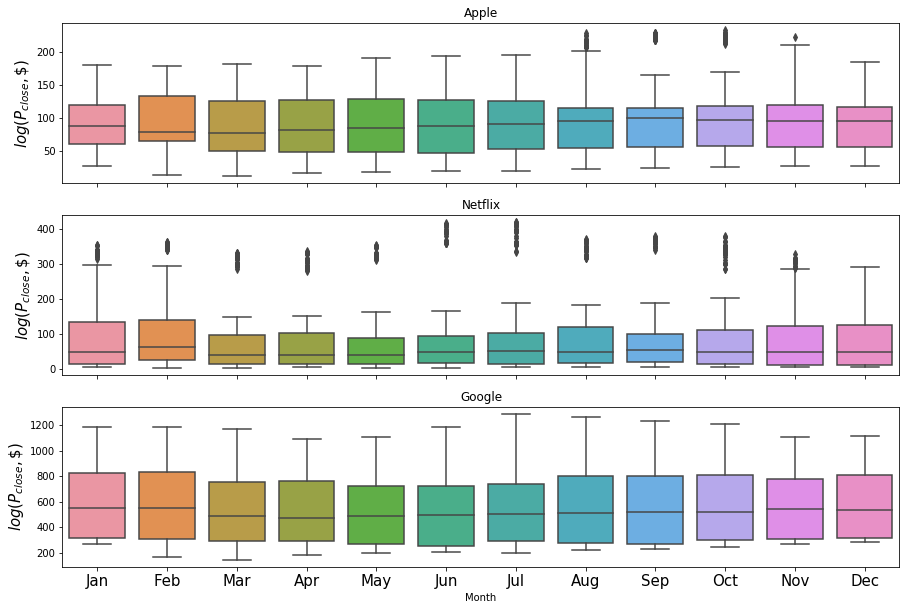

In [7]:
# duplicate copy
df_ses = df_close
# Add columns with year, month, and weekday name
df_ses['Year'] = df_ses.index.year
df_ses['Month'] = df_ses.index.month
df_ses['Weekday'] = df_ses.index.weekday_name
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
for n, ax in zip(stock_names, axs):
    sns.boxplot(data=df_ses, x='Month', y=n, ax=ax)
    ax.set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    ax.set_title(n)
    ax.set_xticklabels(months, size = '15')
    if ax != axs[-1]:
        ax.set_xlabel('')

# Time Series Decomposition

A time series can be statistically broken down into simpler components that represent underlying pattern. These patterns are usually repersented by the trend, seasonality and noise of the time series.

### Trend
Trend presents the overall increase or decrease in the time series magnitude over a relatively longer period of time.
### Seasonality
Seasonality has characteristic of fixed frequency. Usually a time series shows variation based on the seasonal variation along the claender year.
### Noise
Randomness in the data after all other components from the original time series have been removed.

Our main goal is to divide the time series in different components that when combined in some manner gives back the original time series.
The components can be simply added or multiplied.

A time series decompoistion model can be additive or mulitplicative
$$y\left(t\right) = y_{trend}\left(t\right) + y_{seasonal}\left(t\right) + y_{noise}\left(t\right) $$

$$y\left(t\right) = y_{trend}\left(t\right) \times y_{seasonal}\left(t\right) \times y_{noise}\left(t\right) $$

The question is which model to use. Lets explore both options.

In [8]:
def timedecomp(stockname, pltcolor, add = True):
    ts = df_close[stockname]
    if add:
        tsA = seasonal_decompose(ts, model='additive')
        title_label = 'Additive Decomposition'
    else:
        tsA = seasonal_decompose(ts, model='multiplicative')
        title_label = 'Multiplicative Decomposition'
    
    fig1 = plt.figure(figsize = (15,10))
    gs1 = gridspec.GridSpec(4, 5, figure = fig1,wspace=0.05, hspace=0.1)
    # Plot the original time series 
    ax1 = plt.subplot(gs1[0, :-1])
    ts.plot(ax = ax1, color = pltcolor)
    ax1.grid()
    ax1.set_title('{} - {}'.format(stockname,title_label), size = '14')
    ax1.set_ylabel('Closing Price, $', size = '14')
    ax11 = plt.subplot(gs1[0, -1], sharey = ax1)
    ax11.hist(ts.dropna(), 30, orientation='horizontal', color = pltcolor, alpha = 0.6);
    ax11.grid()
    # Plot the trend component
    ax2 = plt.subplot(gs1[1, :-1], sharex = ax1)
    tsA.trend.plot(ax = ax2, color = pltcolor)
    ax2.grid()
    ax2.set_ylabel('Trend, $', size = '14')
    ax22 = plt.subplot(gs1[1, -1], sharey = ax2, sharex = ax11)
    ax22.hist(tsA.trend.dropna(), 30, orientation='horizontal', color = pltcolor, alpha = 0.6);
    ax22.grid()
    # Plot the seasonal component
    ax3 = plt.subplot(gs1[2, :-1], sharex = ax2)
    tsA.seasonal.plot(ax = ax3, color = pltcolor,linestyle = ':')
    ax3.grid()
    ax3.set_ylabel('Seasonal, $', size = '14')
    ax33 = plt.subplot(gs1[2, -1],sharey=ax3, sharex = ax22)
    ax33.hist(tsA.seasonal.dropna(), 30, orientation='horizontal', color = pltcolor, alpha = 0.6);
    ax33.grid()
    # plot the residual component
    ax4 = plt.subplot(gs1[3, :-1])
    tsA.resid.plot(ax = ax4, color = pltcolor)
    ax4.grid()
    ax4.set_ylabel('Residual, $', size = '14')
    ax4.set_xlabel('Date', size = '14')
    ax44 = plt.subplot(gs1[3, -1], sharey = ax4, sharex = ax33)
    ax44.hist(tsA.resid.dropna(), 30, orientation='horizontal', color = pltcolor, alpha = 0.6);
    ax44.grid()
    plt.setp(ax44.get_yticklabels(), visible=False);
    ax44.set_xlabel('Frequency', size = '14')
    ax44.set_ylabel('MSE = {:0.1f}, RMSE = {:0.1f}'.format(np.var(tsA.resid),np.std(tsA.resid)), rotation=270, labelpad=10)
    ax44.yaxis.set_label_position("right")

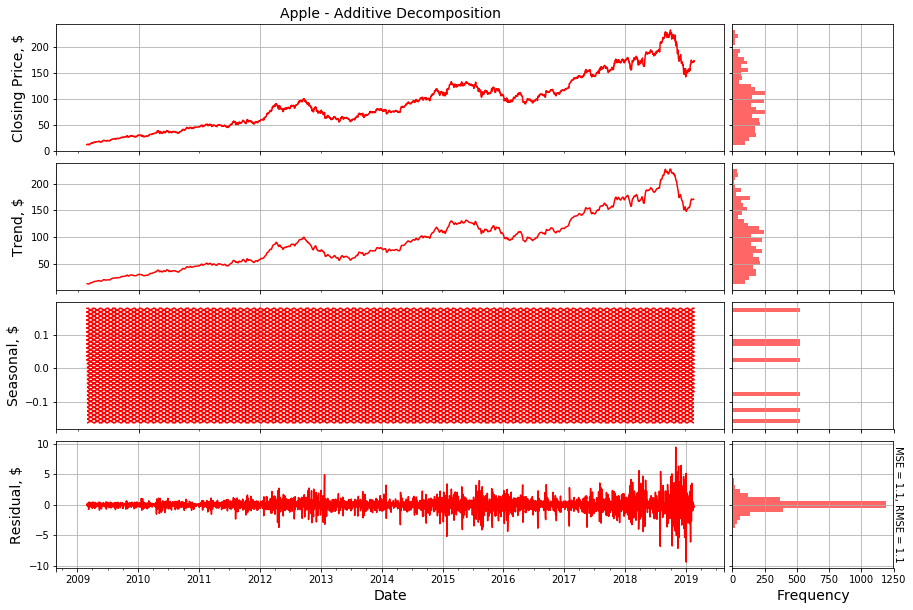

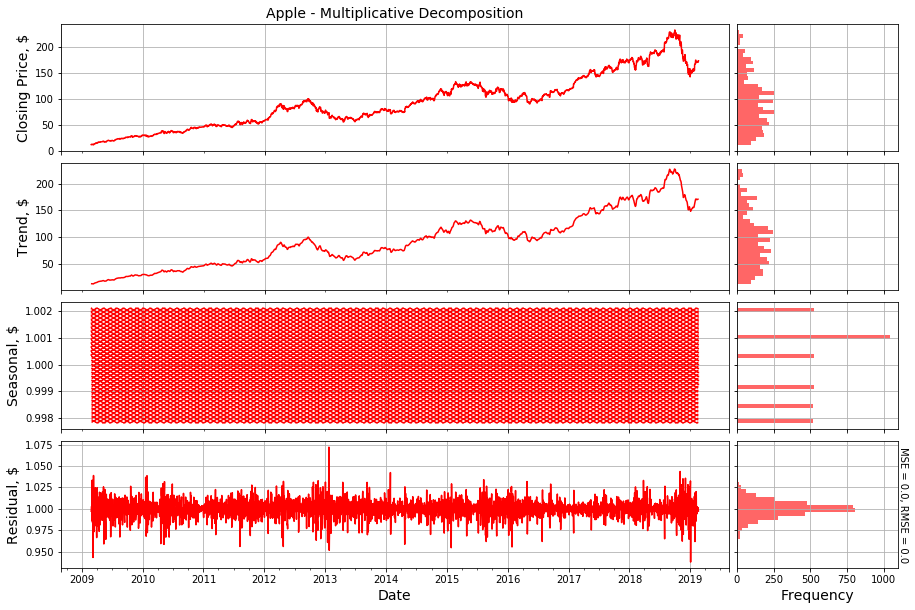

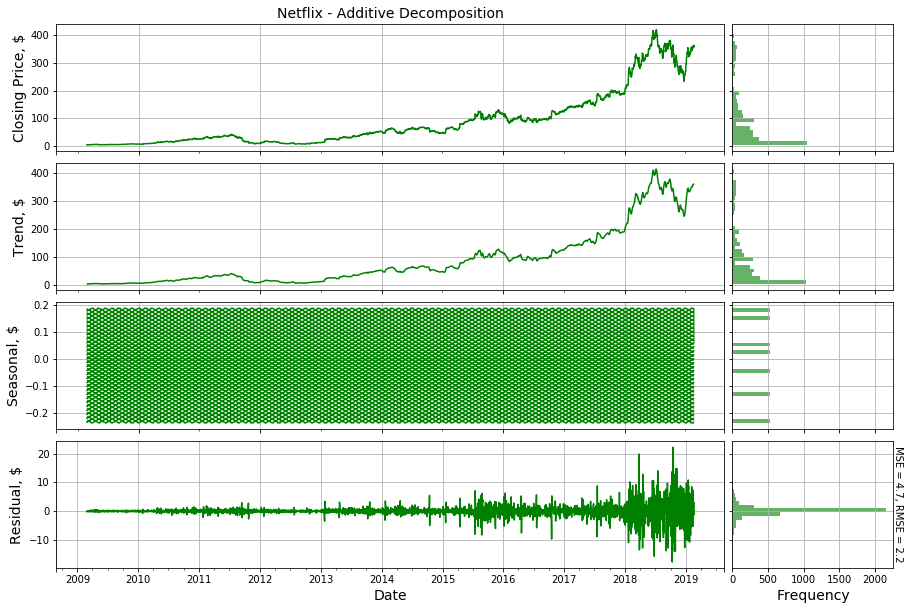

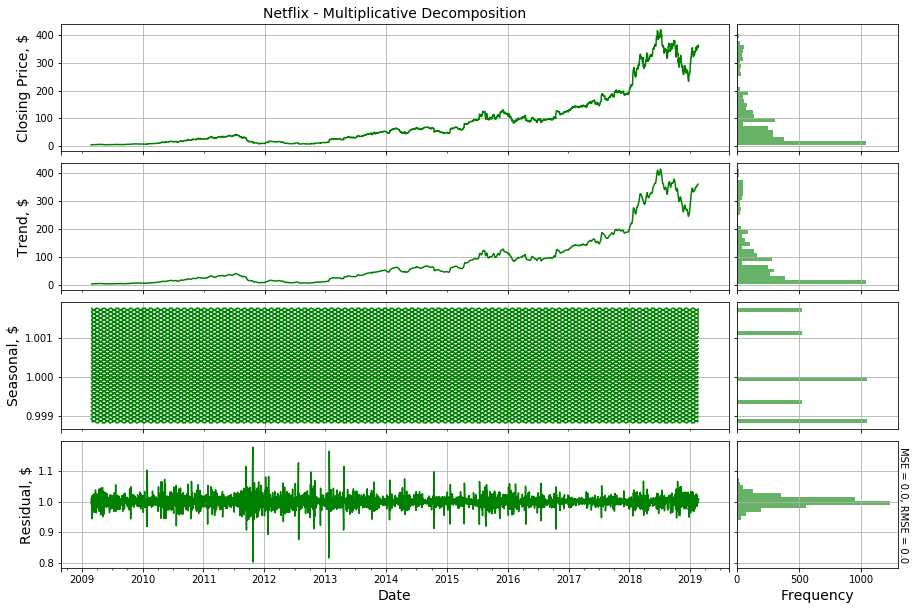

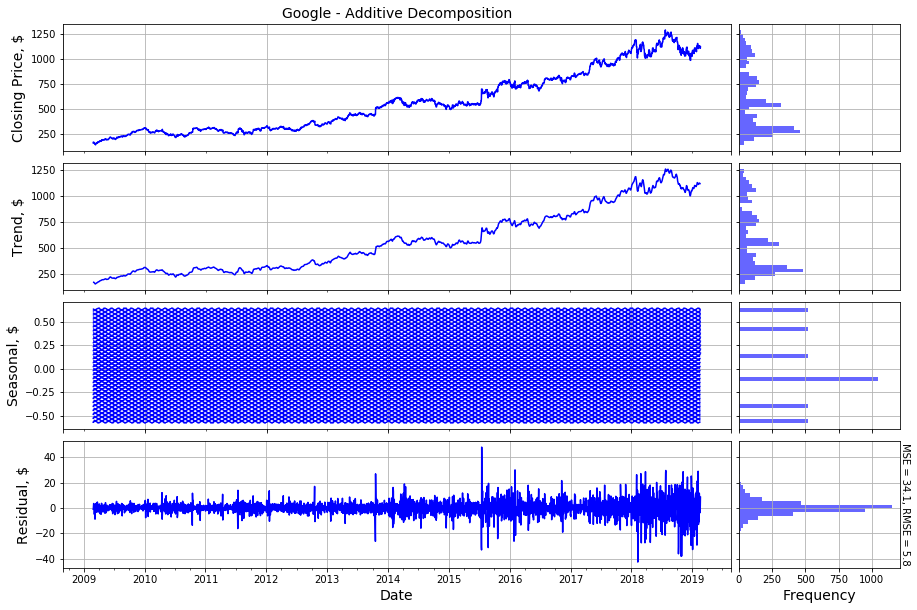

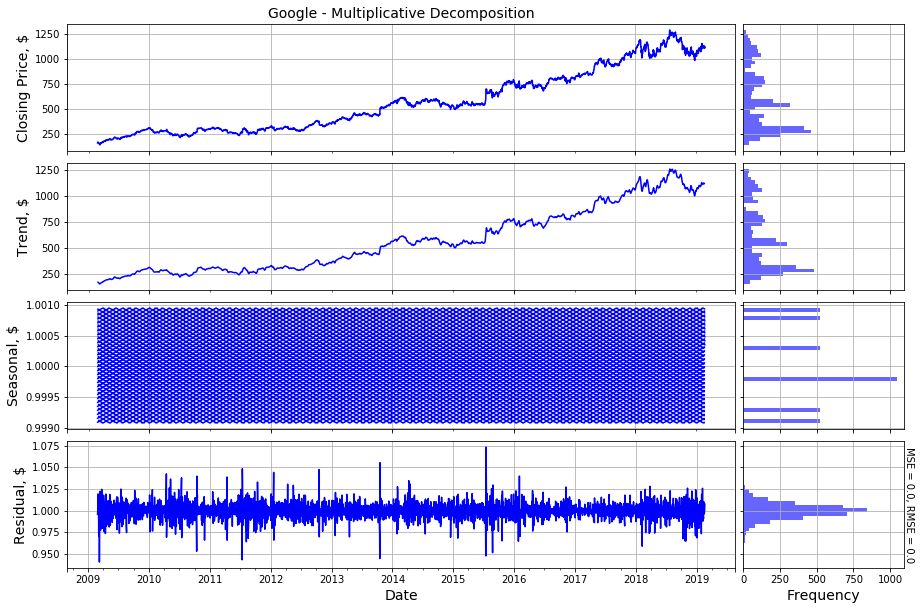

In [9]:
colors = ['r','g','b']
for i in range(3):
    timedecomp(stock_names[i],colors[i])
    timedecomp(stock_names[i],colors[i], False)

# Error Measures

One way to confirm the choice between the additive and the multiplicative decompoistion is to consider the residual variance (MSE) and standard deviation (RMSE).


In [10]:
def error_measures(time_series, decomp_type = "+"):
    # Compute the residual
    if decomp_type == 'x':
        ts = seasonal_decompose(time_series, model='multiplicative')       
    else:
        ts = seasonal_decompose(time_series, model='additive')
    
    res = ts.resid.fillna(0)
    SSE = np.sum(res**2)
    MSE = np.mean(res**2)
    RMSE = np.sqrt(MSE)             
    return np.round(SSE,2),np.round(MSE,2),np.round(RMSE,2)

In [11]:
Error_dict = {}
for i in range(3):
    Error_dict[stock_names[i]+'_add'] = error_measures(df_close[stock_names[i]],'+')
    Error_dict[stock_names[i]+'_mult'] = error_measures(df_close[stock_names[i]],'x')
df_error = pd.DataFrame(Error_dict,index = ['SSE','MSE','RMSE'])
df_error

,Apple_add,Apple_mult,Netflix_add,Netflix_mult,Google_add,Google_mult
SSE,4022.80,3645.93,17194.01,3645.92,124493.42,3645.97
MSE,1.10,1.00,4.71,1.00,34.09,1.00
RMSE,1.05,1.00,2.17,1.00,5.84,1.00


In [12]:
Error_dict = {}
for i in range(3):
    Error_dict[stock_names[i]+'_add'] = error_measures(df_logc[stock_names[i]],'+')
    Error_dict[stock_names[i]+'_mult'] = error_measures(df_logc[stock_names[i]],'x')
df_error = pd.DataFrame(Error_dict,index = ['SSE','MSE','RMSE'])
df_error

,Apple_add,Apple_mult,Netflix_add,Netflix_mult,Google_add,Google_mult
SSE,0.39,3645.99,1.60,3646.01,0.33,3646.0
MSE,0.00,1.00,0.00,1.00,0.00,1.0
RMSE,0.01,1.00,0.02,1.00,0.01,1.0


The error measures provide insight into one way to select the decomposition method. In the original series, mutliplicative decomposition is superior in terms of relativly low variance. In case of log-transformed time series additive decomposition is favord. Note that additive decomposition of log-transformed series is effectively same as multiplicative decomposition of the original series.

# Residual Plots After Log-Transformation

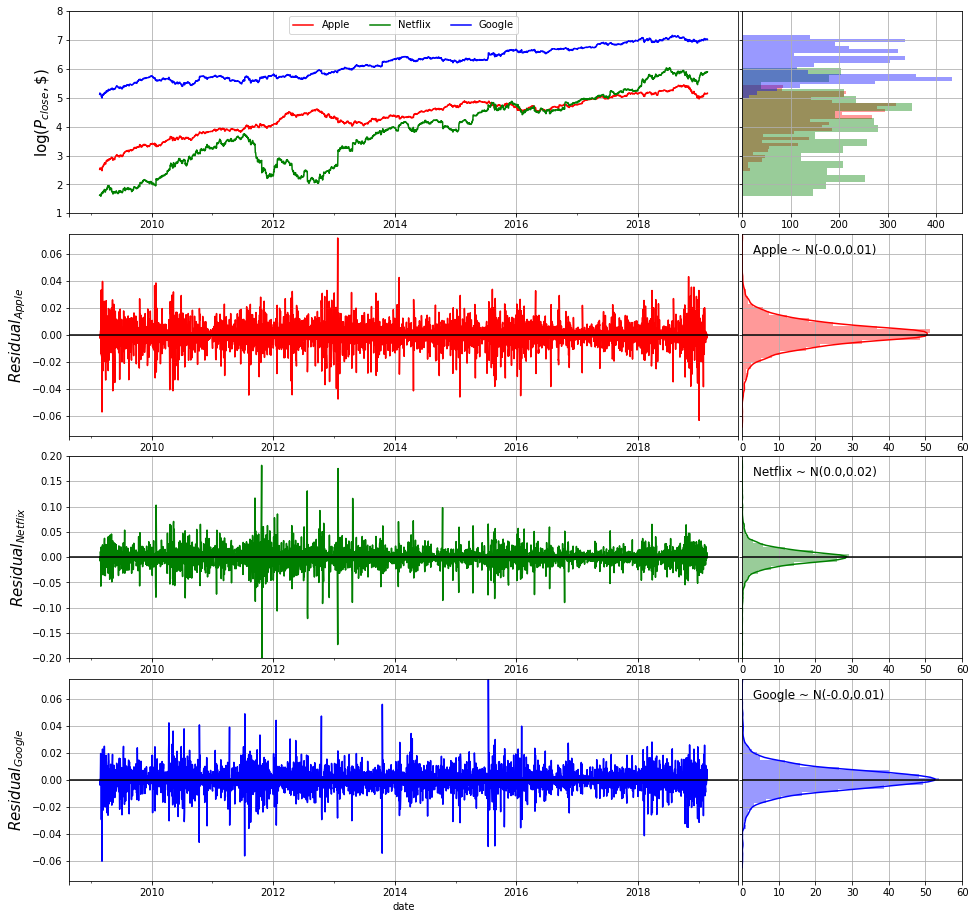

In [13]:
fig = plt.figure(figsize = (16,16))
grid = plt.GridSpec(4, 4,figure = fig, wspace=0.02, hspace=0.1)
for i in range(3):
    tsa = seasonal_decompose(df_logc.iloc[:,i], model='additive')
    tsa_resd = tsa.resid.fillna(0)
    plt.subplot(grid[0, :3])
    df_logc.iloc[:,i].plot(color = colors[i])
    plt.ylabel(r'$\log(P_{close}, \$)$', size = '15')
    plt.legend(stock_names,loc = 'upper center', ncol = 3)
    plt.ylim(1,8)
    plt.grid()
   
    plt.subplot(grid[0, 3]) 
    ax= sns.distplot(df_logc.iloc[:,i], color = colors[i], vertical=True, kde = False)
    plt.ylim(1,8)
    plt.grid()
    plt.setp(ax.get_yticklabels(), visible=False);
    
    plt.ylabel('')
    
    plt.subplot(grid[i+1,:3])
    tsa_resd.plot(color = colors[i])
    plt.axhline(color = 'black')
    plt.ylabel(r'$Residual_{%s}$'%(stock_names[i]), size = '15')
    plt.grid()
    if i == 1:
        plt.ylim([-0.2,0.2])
    else:
        plt.ylim([-0.075,0.075])
    
    plt.subplot(grid[i+1,3])
    ax = sns.distplot(tsa_resd, color = colors[i], vertical=True)
    plt.axhline(color = 'black')
    label = '{} ~ N({:.1f},{:.2f})'.format(stock_names[i],np.mean(tsa_resd),np.std(tsa_resd))
    ax.annotate(label, (0.05, 0.9), xycoords='axes fraction', size = '12')
    plt.setp(ax.get_yticklabels(), visible=False);
    plt.xlim(0,60)
    plt.ylabel('')
    plt.grid()
    if i == 1:
        plt.ylim([-0.2,0.2])
    else:
        plt.ylim([-0.075,0.075])
    

# TIME SERIES ANALYSIS

In [23]:
stock_names = ['Apple','Netflix','Google']
# Define empty dataframe to store the stock closing prices
df = pd.DataFrame()
for stock in stock_names:
    # Read the stock closing prices with date as the index column.
    df[stock] = pd.read_csv(stock+'.csv',parse_dates= [0], index_col = 'date',skiprows = [1]).close
# Rearange the data in ascending chronological order
df = df.sort_index()
# Forward fill the missing holiday and weekend stock closing prices
df = df.resample('D').ffill()
# Log-transform the closing price data frame
df_log = np.log(df)
# Display first five five rows of the data frame
df_log.head()

,Apple,Netflix,Google
date,,,
2009-02-23,2.519421,1.625882,5.116364
2009-02-24,2.556677,1.639269,5.161938
2009-02-25,2.566709,1.631767,5.150848
2009-02-26,2.544857,1.631473,5.137707
2009-02-27,2.546206,1.644245,5.140106


# Mean Absolute Percentage Error

In [24]:
def MAPE(y_true,y_pred):
    """  input:
    y_true = True value of variables
    y_pred = predicted values of variable
    output:
    MAPE = mean absolute percentage error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred) # make sure input is flat   
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Naive Method

In [25]:
# split data into training and test sets
train =  df_log.loc[:'2019-01-31',:]
test =  df_log.loc['2019-02-01':,:]

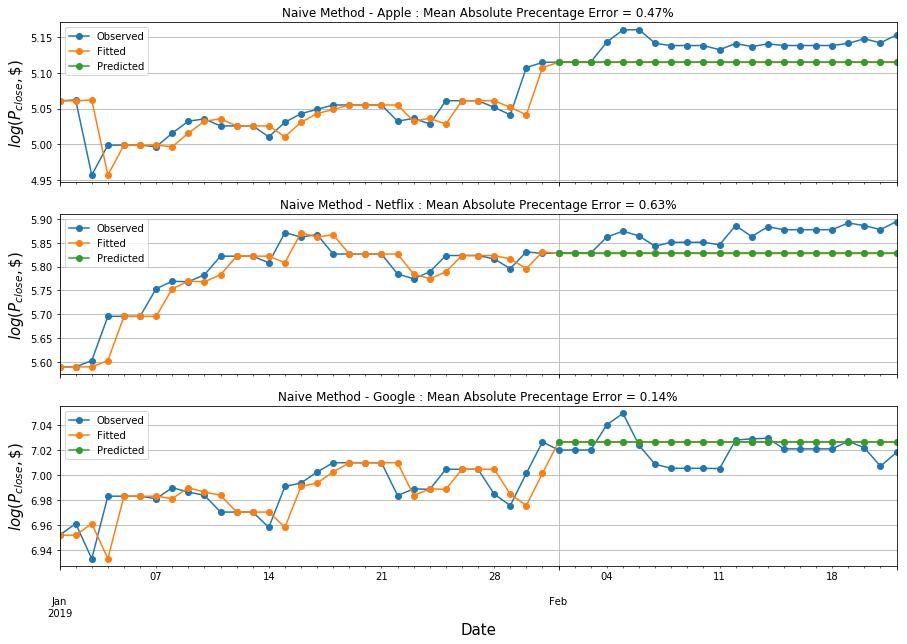

In [40]:
# Creatw empty Data Frame
model_pred = pd.DataFrame(index =df_logc.index )
# Initialize subplots
for i in range(3):
    # Fitted values are observations are lag 1
    train_pred = train.iloc[:,i].shift(1)
    # flat prediction function
    test_pred = np.full((len(test),),train.iloc[-1,i])
    # tolist() way to combine two nd.arrays
    model_pred[stock_names[i]] = train_pred.tolist()+test_pred.tolist()
    # Compute Naive model MAPE
    mape = MAPE(df_logc.loc['2019-02-01':,stock_names[i]],model_pred.loc['2019-02-01':,stock_names[i]])
    # Plot the original and model fits
    df_log.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o')
    model_pred.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o')
    model_pred.loc['2019-02-01':,stock_names[i]].plot(ax = axs[i], marker = 'o')
    
    axs[i].set_xlim('2019-01-01','2019-02-22')
    axs[i].legend(['Observed','Fitted','Predicted'],loc = 'upper left')
    axs[i].grid()
    axs[i].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[i].set_title('Naive Method - {} : Mean Absolute Precentage Error = {}%'.format(stock_names[i],round(mape,2)))
    
plt.show()

# Average Method

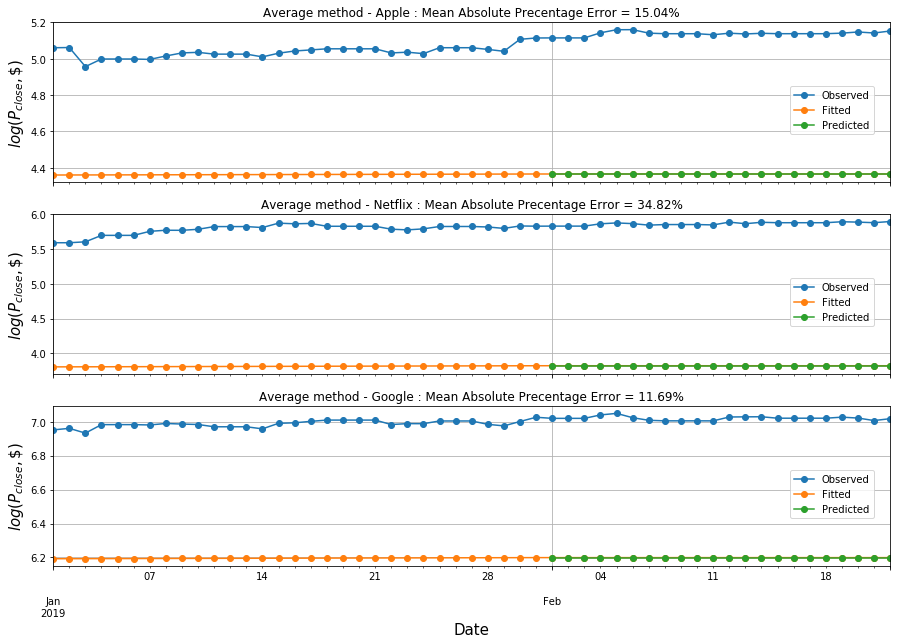

In [46]:
# Creatw empty Data Frame
model_pred = pd.DataFrame(index =df_logc.index )
# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):
    # dummy variable for training data
    train_fit = []
    for j in range(len(train)):
        # Fit the training data as average of all past values
        train_fit.append(np.mean(train.iloc[:j+1,i]))
    # Fit the test data as the average of training set
    test_fit = [np.mean(train.iloc[:,i])]*len(test)
    # Combine training and test data
    model_pred[stock_names[i]] = np.array(train_fit+test_fit)
    # Compute Mape of Average mothod
    mape = MAPE(df_logc.loc['2019-02-01':,stock_names[i]],model_pred.loc['2019-02-01':,stock_names[i]])
    # Plot the original and model fits
    df_log.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o')
    model_pred.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o')
    model_pred.loc['2019-02-01':,stock_names[i]].plot(ax = axs[i], marker = 'o')
    
    axs[i].set_xlim('2019-01-01','2019-02-22')
    axs[i].legend(['Observed','Fitted','Predicted'],bbox_to_anchor=(0.88, 0.6), loc='upper left', borderaxespad=0.)
    axs[i].grid()
    axs[i].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[i].set_title('Average method - {} : Mean Absolute Precentage Error = {}%'.format(stock_names[i],round(mape,2)))
    
plt.show()

# Simple Exponential Smoothing

In [80]:
# split data into training and test sets
train =  df_log.loc[:'2019-01-31',:]
test =  df_log.loc['2019-02-01':,:]

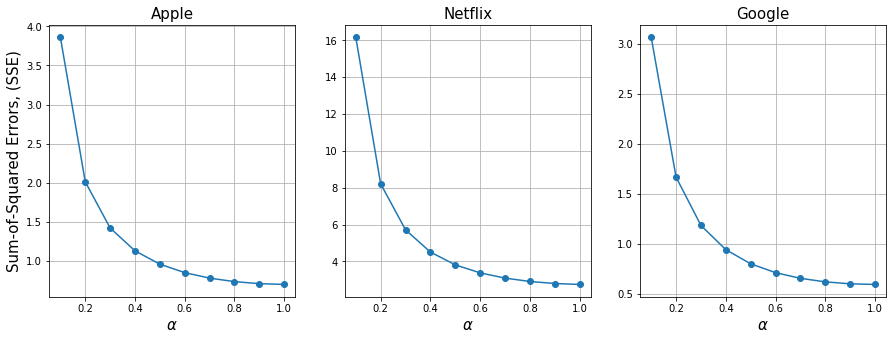

In [104]:
# SSE v/s Smoothing Parameter
df_dict = {}
for i in range(3):    
    SSE = []
    for j in np.arange(0,1.1,0.1):
        model = SimpleExpSmoothing(train.iloc[:,i])
        model_fit = model.fit(smoothing_level=j)
        model_predict = model_fit.forecast(len(test))
        sse = sum((model_fit.fittedvalues-train.iloc[:,i])**2)
        SSE.append(sse)  
    df_dict[stock_names[i]] = SSE
df_smooth = pd.DataFrame(df_dict, index = np.arange(0,1.1,0.1))
fig, axs = plt.subplots(1,3, figsize=(15, 5), facecolor='w', edgecolor='k')
for i in range(3):
    df_smooth.iloc[1:,i].plot(ax = axs[i], marker = 'o')
    axs[i].set_title(stock_names[i], size  = '15')
    axs[i].set_xlabel(r'$\alpha$', size = '15')
    axs[i].grid()
axs[0].set_ylabel('Sum-of-Squared Errors, (SSE)',size = '15');

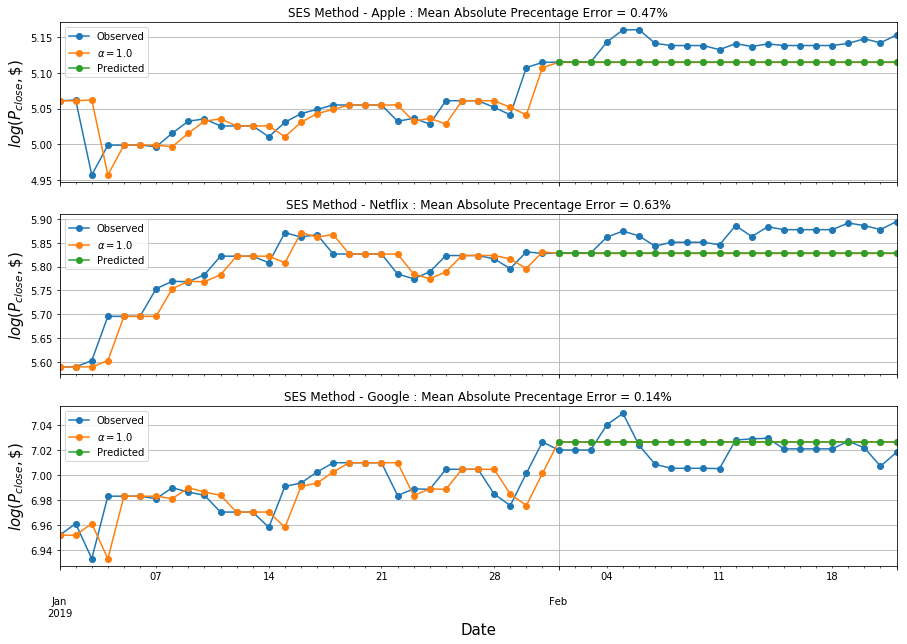

In [132]:
# Simple Exponential Smoothing Fit
# Create Dummy Dataframe
model_pred = pd.DataFrame(index = df_log.index)
# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):    
    # Fit the SES model on train set
    model = SimpleExpSmoothing(train.iloc[:,i])
    model_fit = model.fit()
    # Compute the model predictions
    model_predict = model_fit.forecast(len(test))
    model_pred[stock_names[i]] = pd.concat((model_fit.fittedvalues,model_predict),axis = 0)
    # Compute SES MAPE
    mape = MAPE(df_log.loc['2019-02-01':,stock_names[i]],model_predict)
    # Plot the original and model fits
    df_log.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o', label ='Observed')
    model_pred.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o', label = r'$\alpha=%s$'%model_fit.model.params['smoothing_level'])
    model_pred.loc['2019-02-01':,stock_names[i]].plot(ax = axs[i], marker = 'o', label = 'Predicted')
    
    axs[i].set_xlim('2019-01-01','2019-02-22')
    axs[i].legend(loc = 'upper left')
    axs[i].grid()
    axs[i].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[i].set_title('SES Method - {} : Mean Absolute Precentage Error = {}%'.format(stock_names[i],round(mape,2)))
    
plt.show()
    

# Holt's Linear Trend Method

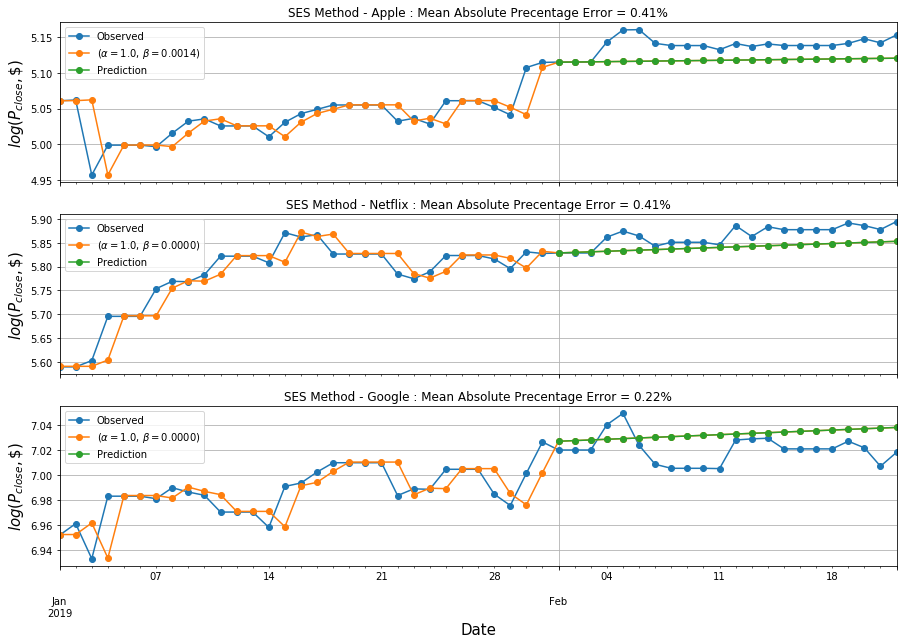

In [130]:
# Holt's Linear trend Fit
# Create Dummy Dataframe
model_pred = pd.DataFrame(index = df_log.index)
# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):    
    # Fit the Holt's model on train set
    model = Holt(train.iloc[:,i])
    model_fit = model.fit()
    # Compute the model predictions
    model_predict = model_fit.forecast(len(test))
    model_pred[stock_names[i]] = pd.concat((model_fit.fittedvalues,model_predict),axis = 0)
    # Compute SES MAPE
    mape = MAPE(df_log.loc['2019-02-01':,stock_names[i]],model_predict)
    # Plot the original and model fits
    df_log.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o', label = 'Observed')
    model_pred.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o',
                                                      label = (r'$\alpha=%s$'%model_fit.model.params['smoothing_level'],
                                                               r'$\beta=%0.4f$'%model_fit.model.params['smoothing_slope']))
    model_pred.loc['2019-02-01':,stock_names[i]].plot(ax = axs[i], marker = 'o',label = 'Prediction')
    
    axs[i].set_xlim('2019-01-01','2019-02-22')
    axs[i].legend(loc = 'upper left')
    axs[i].grid()
    axs[i].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[i].set_title('Holt Method - {} : Mean Absolute Precentage Error = {}%'.format(stock_names[i],round(mape,2)))
    
plt.show()
    

# Holt's Damped Trend Method

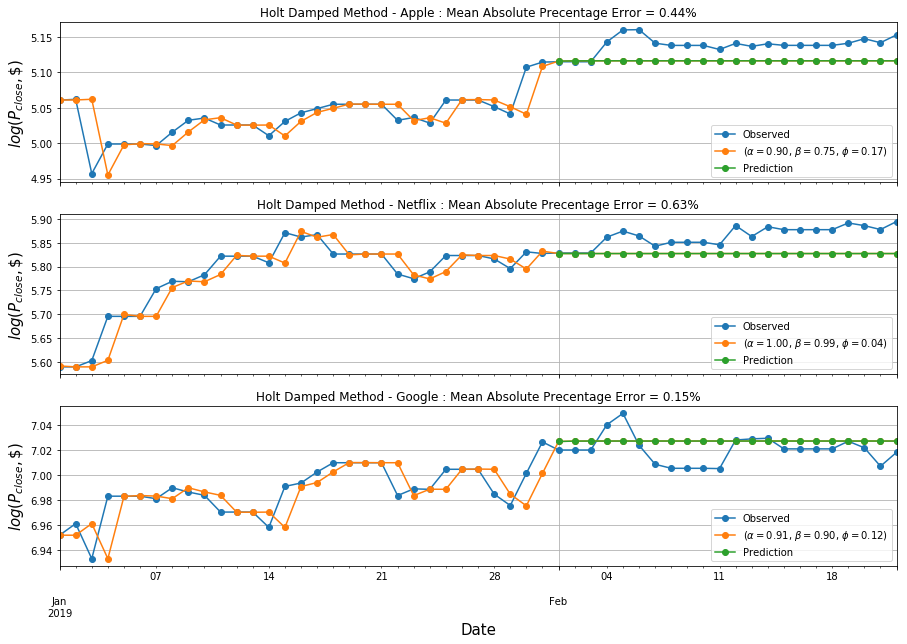

In [135]:
# Holt's Damped trend Fit
# Create Dummy Dataframe
model_pred = pd.DataFrame(index = df_log.index)
# Initialize subplots
fig, axs = plt.subplots(3,1, figsize=(15, 10), facecolor='w', edgecolor='k',sharex = True)
for i in range(3):    
    # Fit the Holt's model on train set
    model = Holt(train.iloc[:,i], damped = True)
    model_fit = model.fit()
    #model_fit = model.fit(damping_slope = 0.8, optimized=True)
    
    # Compute the model predictions
    model_predict = model_fit.forecast(len(test))
    model_pred[stock_names[i]] = pd.concat((model_fit.fittedvalues,model_predict),axis = 0)
    # Compute SES MAPE
    mape = MAPE(df_log.loc['2019-02-01':,stock_names[i]],model_predict)
    # Plot the original and model fits
    df_log.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o', label = 'Observed')
    model_pred.loc['2019-01-01':,stock_names[i]].plot(ax = axs[i], marker = 'o',
                                                      label = (r'$\alpha=%0.2f$'%model_fit.model.params['smoothing_level'],
                                                           r'$\beta=%0.2f$'%model_fit.model.params['smoothing_slope'],
                                                          r'$\phi=%0.2f$'%model_fit.model.params['damping_slope']))
    model_pred.loc['2019-02-01':,stock_names[i]].plot(ax = axs[i], marker = 'o',label = 'Prediction')
    
    axs[i].set_xlim('2019-01-01','2019-02-22')
    axs[i].legend(loc = 'lower right')
    axs[i].grid()
    axs[i].set_xlabel('Date',size = '15')
    axs[i].set_ylabel(r'$log(P_{close} ,\$ $)', size = '15')
    axs[i].set_title('Holt Damped Method - {} : Mean Absolute Precentage Error = {}%'.format(stock_names[i],round(mape,2)))
    
plt.show()